# <center>Identifying Hateful Twitter Users</center>
### <center>Caroline Horsch and Edmund Horsch</center>
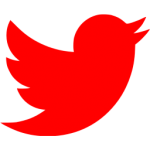

### What are hateful users?
Social media is a great way for people to learn, connect, and support each other. Unfortunately, this positive environment is ruined when users contribute hateful content. Twitter especially is a website where hate speech has become a huge problem. On twitter's <a href = "https://help.twitter.com/en/rules-and-policies/hateful-conduct-policy">Hateful Conduct Policy</a> webpage, they define the types of conduct and content that are considered "hateful".
>__Hateful conduct:__ 
You may not promote violence against or directly attack or threaten other people on the basis of race, ethnicity, national origin, sexual orientation, gender, gender identity, religious affiliation, age, disability, or serious disease. We also do not allow accounts whose primary purpose is inciting harm towards others on the basis of these categories.

### Why do we want to identify hateful users?
Over the years, twitter has been implementing new rules and increasing moderation in order to reduce abusive interactions on their website. One effective way to reduce hate speech is to ban or block hateful users, so that they can no longer contribute hurtful content. If we can correctly identify which users are hateful, we can stop those users from posting to the website, and eliminate abusive content on twitter. 

In the context of data science, identifying hateful users is an interesting problem. For this data, there are both language features and network information to take into account. This lets us explore and evaluate different kinds of data and find ways to integrate them successfully. Additionally, it will allow us to explore some classification machine learning methods.

### How is Data Science useful in identifying hateful users?
After collecting data from twitter about its users, we will be able to analyze this data and search for patterns that suggest a user is abusive. In the end, we will create a model that will take in information from twitter and tell us who is likely to be a hateful user who needs to be removed.
In this tutorial we will be following the data science life cycle in order to perform our task of identifying hateful users. The data science life cycle goes as follows:
<img src = "DataLifecycle.png">
<a hfref = "http://www.cs.umd.edu/class/summer2019/cmsc320/files/Lec01.pdf">Image Source</a>

### Technology Introduction
In this tutorial we are going to be using the following languages, libraries, and technologies. If you want more information on any of these before beginning, follow the link and read up!
<ul>
    <li> <a href = "https://www.python.org/">Python</a>
    <li> <a href = "https://pandas.pydata.org/">pandas</a>
    <li> <a href = "https://numpy.org/">numpy</a>
    <li> <a href = "https://matplotlib.org/">matplotlib</a>
    <li> <a href = "https://scikit-learn.org/stable/"> Sci-Kit Learn</a>
    <li> <a href = "https://networkx.github.io/">networkx</a>
</ul>

In [16]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import networkx as nx

## Data Collection

The data we are using is a dataset found on kaggle, a website where users can upload datasets for public use. The dataset can be found and downloaded from <a href = "https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter">here.</a> 

#### Data Size
This dataset contains information for over 100,000 users, with 5,000 of those users being labelled as either hateful or normal. The label of the remaining users is unknown. The size of the dataset is 100386 rows (or observations, or users) and 1039 columns (or attributes, or predictors).

#### Data Content
For each of the users, the dataset contains information about their activity (followers, folowees, retweets, likes, etc.), their network (who they are connected to, centrality measurements, etc.), and their content (what kinds of things they are writing about). 

Let's get started! To begin working with the data, download the data set from the kaggle link above and read it into a pandas dataframe. Then, to get a feel for what kind of information we have, let's print a list of all of the attributes.

In [2]:
data = pd.read_csv('hateful-users-on-twitter/users_neighborhood_anon.csv')

In [3]:
data.columns

Index(['user_id', 'hate', 'hate_neigh', 'normal_neigh', 'statuses_count',
       'followers_count', 'followees_count', 'favorites_count', 'listed_count',
       'betweenness',
       ...
       'c_feminine_empath', 'c_medieval_empath', 'c_journalism_empath',
       'c_farming_empath', 'c_plant_empath', 'c_shopping_empath',
       'c_ship_empath', 'c_religion_empath', 'c_tourism_empath',
       'c_power_empath'],
      dtype='object', length=1039)

## Data Processing
#### Glove Vectors
Now that we have our data and unserstand a little bit about it, we want to clean it up to make it easier to read and understand. We won't be using the 'glove' attributes, so let's delete those columns now. This considerably reduces the number of columns we much evaluate from over 1,000 to 439. 

In [4]:
for col in data.columns:
    if re.match(r"^.*glove$", col):
        del data[col]
data.columns

Index(['user_id', 'hate', 'hate_neigh', 'normal_neigh', 'statuses_count',
       'followers_count', 'followees_count', 'favorites_count', 'listed_count',
       'betweenness',
       ...
       'c_feminine_empath', 'c_medieval_empath', 'c_journalism_empath',
       'c_farming_empath', 'c_plant_empath', 'c_shopping_empath',
       'c_ship_empath', 'c_religion_empath', 'c_tourism_empath',
       'c_power_empath'],
      dtype='object', length=439)

#### Empath Attributes
Now let's try to pick out the attributes that seem to have the biggest gap between normal and hateful users. Let's begin with the empath attributes. The empath values represent what percentage of words from the user's last 200 tweets fell into the different categories. The values are calculated with the equation:

$$\text{Empath} = \frac{\text{number of words used that fall into this category}}{\text{total number of words}}$$

An example would be 'feminine_empath' gives the percentage of words from the user's last 200 tweets that are considered feminine. 

Empath attributes beginning with "c_" indicate that this is the language the people they are interacting with use. 

#### Picking Empath Attributes
To find the significant attributes, I want to look for the empath attributes that are at least 2 times higher or lower on average for hateful users when compared to normal users.To do this, I will just loop through each attribute, check that  it is an empath attribute using <a href = "https://en.wikipedia.org/wiki/Regular_expression">regular expressions</a>, and calculate the means. After this operation I'm left with a list of the attributes where hateful and normal users differ the most. 

In [5]:
#Find the significant atributes 
significant_atts = []
significant_atts_labels = []
for att in data.columns:
    if re.match(r"^.*_empath$", att):
        a = data[att][data['hate']=='hateful'].mean()
        b = data[att][data['hate']=='normal'].mean()
        if(a/b > 2 or b/a > 2):
            significant_atts.append((att, a, b))
            significant_atts_labels.append(att)
len(significant_atts)

8

Now we have found just 8 attributes that we have determined are very significant. This is much better than having to consider over 500 different language categories in our analysis. 

## Exploratory Analysis & Data Visualization

With all of our data imported and ready to look through, let's begin visualizing and analyzing some of our data. Let's look at how the normal users compare to the hateful users for these language categories. Here we use matplotlib's pyplot library to plot a bar chart for the average values for each attribute.

Language Categories


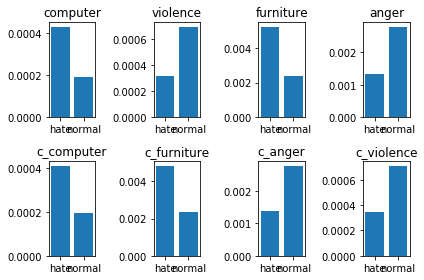

In [6]:
#Plot the significant attributes
fig, ax = plt.subplots(2, 4)
print("Language Categories")
for i, att in enumerate(significant_atts):
    ax[i//4] [i%4].bar(['hate', 'normal'],[att[1], att[2]])
    ax[i//4] [i%4].set_title(att[0][0:-7])
    plt.tight_layout()
plt.tight_layout()

Interesting result! For some reason, hateful users are talking about furniture twice as much as normal users. Additionally, there are some counterintuitive results here. It seems that hateful users are using violent and angry language half as often as normal users. I'm not sure exactly what these results mean. Perhaps users who were using excessive violent or angry language have already been removed from the site, so they won't show up in our data.

#### Followers to Follows Ratio
Another attribute that could potentially predict hateful status is the followers to follows ratio. Perhaps if a user has less followers than they have people they follow, it might indicate that people don't want to follow this user because they are abusive. Here we will create two new dataframes to more easily access and manipulate our data. One will hold follower and followee information for hateful users, and one for normal. Using this information, we calculate a new column in these dataframes: ratio. 

In [7]:
ratios_hateful = pd.DataFrame()
ratios_hateful['follows'] = data['followees_count'][data['hate'] == 'hateful']
ratios_hateful['followers'] = data['followers_count'][data['hate'] == 'hateful']
ratios_hateful['ratio'] = ratios_hateful['followers']/ratios_hateful['follows']

ratios_normal = pd.DataFrame()
ratios_normal['follows'] = data['followees_count'][data['hate'] == 'normal']
ratios_normal['followers'] = data['followers_count'][data['hate'] == 'normal']
ratios_normal['ratio'] = ratios_normal['followers']/ratios_normal['follows']

Now that we have our data stored, lets use matplotlib's hist() function to plot the distributions and calculate the medians. 

Normal Median =  1.8742424242424243
Hateful Median =  1.3355439383026761


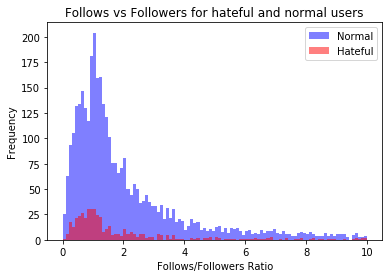

In [8]:
plt.hist(ratios_normal['ratio'][ratios_normal['follows'] != 0], bins = 100, color = 'blue', range = (0, 10), alpha = 0.5)
plt.hist(ratios_hateful['ratio'][ratios_hateful['follows'] != 0], bins = 100, color = 'red', range = (0, 10), alpha = 0.5)
plt.xlabel("Follows/Followers Ratio")
plt.ylabel("Frequency")
plt.title("Follows vs Followers for hateful and normal users")
print("Normal Median = ",ratios_normal['ratio'][ratios_normal['follows'] != 0].median())
print("Hateful Median = ",ratios_hateful['ratio'][ratios_hateful['follows'] != 0].median())
plt.legend(['Normal', 'Hateful'])

The distributions here are somewhat similar. They peak between 1 and 2 and then are skewed heavily to the right. However, we see that there is a difference: normal users tend to have a higher ratio than hateful users. The median values are 1.87 for normal users, and 1.34 for hateful users. While this is not a huge difference, it is large enough that we will include it in our model.  

#### Community and Connections
Now that we have language features and followers ratio computed and visualized, let's start visualizing and integrating the graph data. Here we will be using <a href = "https://networkx.github.io/">networkx</a>, a python library for graph creation and analysis. From our kaggle download, we already have a graphml file that we can load directly into networkx. 

In [9]:
graph = nx.read_graphml('users_clean.graphml')

With the graphml file loaded in as a graph in networkx, we can visualize some of the hateful users networks. Here I have picked just a few. We do this by looping through hateful user's IDs (which are a column in our dataframe). Then, using that ID as the origin node for our graph, we plot all of it's neighbors with corresponding colors for hateful and normal users. To make the plot I used matplotlib and networkx's draw_networkx() function. For more information on how networkx's visualization works, follow <a href = "https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html">this link.</a>  Here, we define a neighbor/connection/edge as someone who either follows you or you follow. 

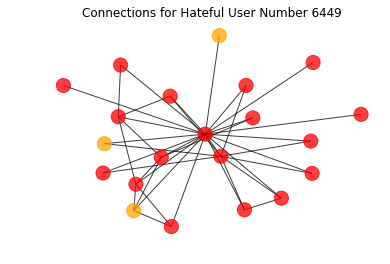

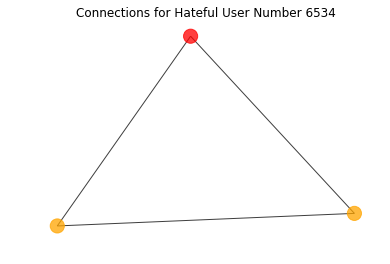

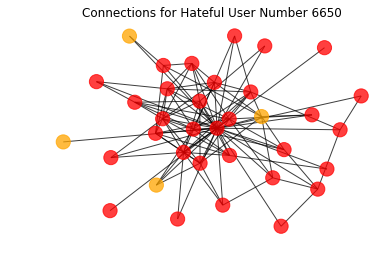

In [10]:
g = graph
nx.number_of_nodes(g)

## loop through a few hateful users:
for index, i in enumerate(data[data['hate'] == 'hateful']['user_id'][23:26]):
    
    plt.figure(index)
    
    g1 = nx.Graph()
    #Define our starting node.
    origin_node = str(data.iloc[i]['user_id'])
    
    node_it = nx.neighbors(graph, origin_node)
    
    # fill the nodes and colors lists:
    colors = []
    nodes = []
    for node in node_it:
        if data.iloc[int(node)]['hate'] == "hateful":
            colors.append('red')
            nodes.append(node)
        elif data.iloc[int(node)]['hate'] == "normal":
            colors.append('orange')
            nodes.append(node)  
    
    # fill the edges list: 
    edges = []
    for node in nodes:
        arr1 = g.in_edges(node)
        arr2 = g.out_edges(node)
        for (i, o) in arr1:
            if (i in nodes) and (o in nodes):
                edges.append((i, o))
        for (i, o) in arr2:
            if (i in nodes) and (o in nodes):
                edges.append((i, o))
    
    g1.add_nodes_from(nodes)
    g1.add_edges_from(edges)
    
    #plot
    plt.title("Connections for Hateful User Number " + origin_node)
    plt.axis('off')
    nx.draw_networkx(g1, node_list=nodes, node_color=colors, with_labels=False, alpha=0.75, node_size = 200)

From looking at just a few of these, it appears that hateful users are connected to many other hateful users. This is a very interesting trait and will be useful to include in our model. 

#### Extracting Numerical Information from the Graph of Users
Now that we have seen that the people a user is connected to seems to depend pretty heavily on whether they are a hateful user or not, let's quantify this observation so we can use it as a predictor in our model. Now we want to add the values for __hateful_neighbors__ and __normal_neighbors__ to our dataframe. 

To do this, we will use the __user_id__ value for each user to match it with the node in the graph. Then, we will loop through that node's neighbors, keeping count of how many are hateful and how many are normal. After we've counted up all of the neighbors, we add our new columns to the dataframe.

In [11]:
# add a column for "hateful neighbors" and "normal neighbors"
df = data[data['hate'] != "other"]

hateful_neighbors = []
normal_neighbors = []
ratio = []

#Loop through all users
for i in df['user_id']:
    
    num_hateful = 0
    num_normal = 0
    
    g1 = nx.Graph()
    origin_node = str(data.iloc[i]['user_id'])
    
    node_it = nx.neighbors(graph, origin_node)
    
    # Look through all neighboring users
    nodes = []
    for node in node_it:
        if data.loc[int(node)]['hate'] == "hateful":
            num_hateful += 1
        elif data.loc[int(node)]['hate'] == "normal":
            num_normal += 1
    hateful_neighbors.append(num_hateful)
    normal_neighbors.append(num_normal)

In [12]:
#Add new information to our dataframe
data = data[data['hate'] != 'other']
data['hateful_neighbors'] = hateful_neighbors
data['normal_neighbors'] = normal_neighbors

#### Putting Together Our Final Predictors

Now that we have sifted through the data, looked at a few relationships and attributes, and decided on which we want to include, we can now make our final list. Here is what we decided to use as our predictors:
<ol>
    <li> Significant Language Attributes
    <li> Number of Followers
    <li> Number of People the User Follows
    <li> Number of Hateful Connections
    <li> Number of Normal Connections
</ol>

Let's add these to a list so we can easily access just these parameters in our dataframe. 

In [13]:
params = significant_atts_labels
params.append('followees_count')
params.append('followers_count')
params.append('hate')
params.append('hateful_neighbors')
params.append('normal_neighbors')

## Model Creation and Analysis

The fun part! Now that all of our data is organized and we have found the most important characteristics for each user, we can build our model. 

#### Choosing a model

Ultimately, the goal of our model is to be able to predict whether a user is a hateful user that is breaking the twitter conduct rules. So, we want to create a binary classifier that evaluates a user as either hateful or not hateful.

#### Binary Classifiers
There are many different ways to perform binary classification. I want to try three classification algorithms in this tutorial: Logistic Regression, Support Vector Machine, and K Nearest Neighbors.  

### Logistic Regression 

<img src = "sigmoid.png" width = 300 height = 400>

Logistic Regression creates a weight vector that corresponds to each attribute, then uses the dot product of that weight vector and the observation as the argument for the sigmoid function. The sigmoid function is bound below by zero, and above by 1, so this output represents a probability of being in one class or the other. In our case, the two classes will be hateful or not hateful, and our model will predict a probability that a user is hateful.

To learn more about Logistic Regression, how it works, and it's applications, follow some of these links!

<a href = "https://en.wikipedia.org/wiki/Logistic_regression"> Wikipedia </a>

<a href = "https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc"> Medium </a>



### Support Vector Machine

<img src = "svm.png" width = 200 height = 200>

Support Vector Machines work by finding a <a href = "https://en.wikipedia.org/wiki/Hyperplane">hyperplane</a> in predictor space (this just means the n-dimensional space defined by our attributes) that maximizes the distance between the two closest vectors in the two different classes. Using this plane, we can see if our user lies below it, meaning they are not a hateful user, or above it, meaning they are a hateful user. To learn more about Support Vector Machines, follow these links!

<a href = "https://en.wikipedia.org/wiki/Support-vector_machine">Wikipedia</a>

<a href = "https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72">Medium</a>


### K Nearest Neighbors

<img src = "knn.png" width = 200 height = 200>

The K Nearest Neighbor algorithm works by finding the k closest vectors (users) using euclidian distance to our user we wish to classify. Then, we assign whichever classification of those k vectors is most common to our user in question. To learn more about the K Nearest Neighbor algorithm, follow these links!

<a href = "https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm"> Wikipedia </a>

<a href = "https://www.geeksforgeeks.org/k-nearest-neighbours/"> GeeksForGeeks</a>

#### Implementing the algorithms

To implement these algorithms, we are going to use <a href = "https://scikit-learn.org/stable/"> Sci-Kit Learn</a>, a python library that has many machine learning algorithms and tools ready to use with our pandas dataframes. 

To start, we need to separate our data into testing and training data. One set we will use to create our model, then the other set we will use to evaluate the accuracy of the model. We can very conveniently do this with sklearn's train_test_split() function. Here, I've chosen to use 90% of our data for training and 10% for testing. 

In [17]:
#Want to only use the labelled data
df = data[params][data['hate'] != 'other']
df = df.dropna()

#Split data into training and testing
train, test = sklearn.model_selection.train_test_split(df, test_size = 0.1)

#Identify classes for testing and training data
y_train = train['hate']
x_train = train.drop('hate', axis = 1)

y_test = test['hate']
x_test = test.drop('hate', axis = 1)

Now the data should be ready to run through sklearn's logistic regression. Here we make a model, fit the model, and then use the model to find the accuracy of the model on our testing data. 

In [18]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
print("Logistic Regression Accuracy: ", log_reg.score(x_test, y_test))

Logistic Regression Accuracy:  0.9467213114754098


Great! We see we that our model has given us a 94.6% accuracy when predicting whether a user is hateful or not!

Now let's move on to trying the SVM model. Here we use sklearn's SVC (support vector classifier). Again we fit the data to generate a model, and evaluate the model's accuracy.

In [19]:
svm = SVC(gamma='auto')
svm.fit(x_train, y_train)
print("SVM Accuracy: ", svm.score(x_test, y_test))

SVM Accuracy:  0.8811475409836066


We see we have produced an accuracy of 88% using the SVM algorithm.

Next, let's try out the K Nearest Neighbor algorithm. The K Nearest Neighbors model will change depending on what value of k we use. I don't want to use too high of a k value because the number of normal users is much greater than the number of hateful users. Because of this, we might see more irrelevant normal users with a higher k, making our predictions all normal users and therefore inaccurate. Let's try a few different k values. 

In [20]:
k = 2
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
print("K Nearest Neighbors Accuracy for k = ", k, ": ", knn.score(x_test, y_test))
      
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
print("K Nearest Neighbors Accuracy for k = ", k, ": ", knn.score(x_test, y_test))
      
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)
print("K Nearest Neighbors Accuracy for k = ", k, ": ", knn.score(x_test, y_test))

K Nearest Neighbors Accuracy for k =  2 :  0.7397540983606558
K Nearest Neighbors Accuracy for k =  3 :  0.8504098360655737
K Nearest Neighbors Accuracy for k =  5 :  0.8709016393442623


It looks like $k = 5$ is a good value to use, and gives us an accuracy of 87%. 

After considering all of these models, lets look at how their success compares to each other. Here, we will make a few bar plots that show the accuracy of each of the models. This is a good way to visualize how our models have performed and which is best for this kind of classification. 

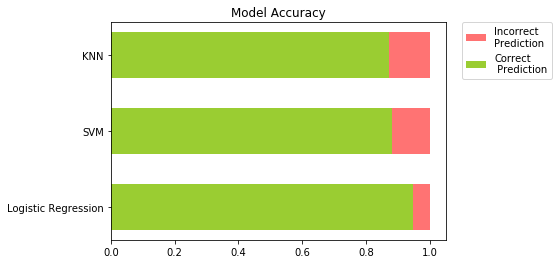

In [21]:
h = 0.6
c = 'red'

# Make Bar plots that show accuracy for each model. 
plt.barh(['Logistic Regression'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['Logistic Regression'], log_reg.score(x_test, y_test), color = 'yellowgreen', alpha = 1, height = h)
plt.barh(['SVM'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['SVM'], svm.score(x_test, y_test), color = 'yellowgreen', alpha = 1, height = h)
plt.barh(['KNN'], 1, color = c, alpha = 0.55, height = h)
plt.barh(['KNN'], knn.score(x_test, y_test), color = 'yellowgreen', alpha = 1, height = h)
plt.title("Model Accuracy")
plt.legend(['Incorrect\nPrediction', 'Correct\n Prediction'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Results

It looks like Logistic Regression has produced the most accurate model! As a guess, I think that the weights present in logistic regression are allowing the most important features to affect the outcome more, and in this case, we saw that the most distinct feature is the very large difference in number of hateful connections for hateful and normal users.

## Conclusion

After determining the most important attributes of a hateful user, we were able to create a logistic regression model that could predict if a user was breaking twitter's conduct rules with 94.2% accuracy. 

Although this result is not perfect, it is a good start. If twitter can improve upon this result and perhaps search for more attributes to consider, they might be able to automatically or nearly automatically moderate the website and remove users who are violating their rules. 

To read more about Twitter analysis related to abuse and hate speech, check out these links:

https://medium.com/@muabusalah/twitter-hate-speech-sentiment-analysis-6060b45b6d2c

https://www.prnewswire.com/news-releases/hate-speech-on-twitter-predicts-frequency-of-real-life-hate-crimes-300873541.html


Thanks for reading and we hope this tutorial was helpful to anyone interested in Data Science!